In [ ]:
# Mount google drive to notebook
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
drive.mount(MOUNTPOINT, force_remount=True)

Mounted at /content/gdrive


In [ ]:
path_to_folder = '/content/gdrive/Shareddrives/RL_MiniHack'

In [ ]:
# Install necessary libraries
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,040 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:14 http://security.ubuntu

In [ ]:
!pip3 install -Uv nle
!pip install minihack
!pip install imageio_ffmpeg

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [ ]:
import numpy as np 
import gym
import minihack 
import nle
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import base64, io
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import cv2
import moviepy
import moviepy.video.io.ImageSequenceClip

In [ ]:
# save directory for tyrrec files
savedir = '/content/gdrive/Shareddrives/RL_MiniHack/save_dir'

In [ ]:
# Set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def formats(state):
    """Get the glyphs and message formate for input into NN"""
    g = state["glyphs"]
    # Normalize
    g = g/g.max()
    
    g = g.reshape((1,1,21,79))
    m = state["message"]
    # check if there is a message
    if m.max()>0: 
        m = m/m.max()
    m = m.reshape((1,len(m)))
    
    state = {"glyphs":g,"message":m}
    return state

In [ ]:
def moving_average(arr, win_size):
    """Compute moving average for returns"""
    sum = np.cumsum(arr, dtype=float)
    sum[win_size:] = sum[win_size:] - sum[:-win_size]
    return sum/win_size

In [ ]:
def compute_returns(rewards, gamma):
    """Compute the returns of a trajectory"""
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    # Standardization       
    if np.std(returns) != 0:
        returns = returns - np.mean(returns)
        returns = returns/ np.std(returns)

    return returns

In [ ]:
def plot_results(env_name,scores, color,ylim):
    """Plots the rewards attained by the agent"""
    
    plt.figure(figsize=(8,6))
    # scores = scores.flatten()
    for score in scores:
      plt.plot(score, alpha =0.1, color=color)
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"Actor Critic - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    plt.yticks(np.arange(ylim[0], ylim[1], 1.00))
    plt.legend(loc=4)
    plt.savefig(f"Actor-Critic-{env_name}.pdf")
    plt.show()  

In [ ]:
def save_video_of_model(agent, env, video_name):
    state = (env.reset())
    video = []
    done = False
    i = 0
    while not done:
        # Append image of state to video array
        video.append(state['pixel'])
        state = formats(state)
        # Get action probabilities and state value from A2C model
        action_probs,state_value = agent.forward(state)
        distribution = torch.distributions.Categorical(action_probs)
        # choose best action
        action = distribution.probs.argmax(dim=1, keepdim=True)
        state, reward, done, _ = env.step(action.item())
    fps=60
    video.append(state['pixel'])
    # Convert images to a video and store in google drive folder
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(video, fps=fps)
    clip.write_videofile("/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/{}.mp4".format(video_name))

In [ ]:
class ActorCritic(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):
        super(ActorCritic, self).__init__()
        # Conv Layer 1
        self.conv1 = Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # Conv layer 2
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # Fully connected layers receiving output from conv layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=128)
        self.relu4 = ReLU()
        # Fully connected Layer for message input 
        self.fc3 = Linear(in_features=256, out_features=128)
        self.relu5 = ReLU()
        # Fully connected Layer for combination of glyphs and message 
        self.fc4 = Linear(in_features=256, out_features=128)
        self.relu6 = ReLU()
        # critic evaluation
        self.value_layer = nn.Linear(128, 1)
        # actor improvement
        self.action_layer = nn.Linear(128, a_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        
        # convert to tensors
        g_forward  = torch.from_numpy(state["glyphs"]).float().to(device)
        m_forward  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional layers 
        g_forward = self.conv1(g_forward)
        g_forward = self.relu1(g_forward)
        g_forward = self.maxpool1(g_forward)
        g_forward = self.conv2(g_forward)
        g_forward = self.relu2(g_forward)
        g_forward = self.maxpool2(g_forward)
        
        # Platten out to be passed into fully connected layers
        g_forward = g_forward.reshape(g_forward.shape[0], -1)
        g_forward = self.fc1(g_forward)
        g_forward = self.relu3(g_forward)
        g_forward = self.fc2(g_forward)
        g_forward = self.relu4(g_forward)
        
        # Pass the message input through a fully connected layer
        m_forward = self.fc3(m_forward)
        m_forward = self.relu5(m_forward)
        
        # Combine glyph and message output
        try:
            combined = torch.cat((g_forward,m_forward),1)
        except:
            combined = torch.concat([g_forward,m_forward],1)

        # Pass combined data to fully connected layer
        combined = self.fc4(combined)
        combined = self.relu6(combined)
        
        # Compute value of state - critic evaluation
        state_value = self.value_layer(combined)
        # Compute policy - Actor improvement
        action_probs = self.action_layer(combined)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

In [ ]:
from datetime import datetime

In [ ]:
def actor_critic(env, model, seed, l_r, num_eps, max_eps_len, gamma, verbose=True, Evaluate = False):
    """
    Train A2C model
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    l_r: The learning rate uesd for the Adam optimizer when training the model 
    num_eps: Number of episodes to train for 
    max_eps_len: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    
    model: The trained A2C NN model after being trained to compute state value functions and action policy
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """
    # Setting random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=l_r)
    # List to store the rewards attained in each episode 
    scores = []
    
    for i in range(num_eps):
        # Array to store Frames of video
        video = []
        # Reset environment
        state = formats(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        # Lists to store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_eps_len):        
            # Get the action probability distribution and estimated   
            # state value function from Actor Critic network 
            action_probs,state_value = model.forward(state)
            distribution = torch.distributions.Categorical(action_probs)
            
            # Sample from the probability distribution to determine which 
            # action to take. If Evaluate = True then we choose the action with
            # highest probability
            if Evaluate:
              action = distribution.probs.argmax(dim=1, keepdim=True)
            else:
              action = distribution.sample()
            
            # print(action)
            # Run selected action on the environment
            next_state, reward, done, _ = env.step(action.item())
            # Append pixel value of the state to produce images  of the state of the game
            video.append(next_state["pixel"])
            
            # Format state into glyphs and message
            next_state = formats(next_state)
    
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            state = next_state
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Create video of episode if agent received positive rewards
        if np.sum(rewards) > 0 and i>0:
            today = datetime.now()
            curr_datetime = str(today.date()) + " " + str(today.hour) + "_" + str(today.minute)
            clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(video, fps=30)
            clip.write_videofile("/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/{}.mp4".format("a2c"+ curr_datetime))

        # Print episode reward and 50 step rolling average of the rewards
        if verbose:
            print("Episode:",i,"Reward:",np.sum(rewards),"Average Reward:",np.mean(scores[-50:]),"Steps",t)
        
        # Calculate the loss for the episode and use it to update the network parameters 
        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            try:
                reward = reward.resize(1,1)
            except:pass
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, scores


In [ ]:
def run_actor_critic(env, num_eps, max_eps_len ,iterations , Evaluate = False):
    """Train Actor Critic model for a given number of episodes"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        # Initialize the Actor Critic Model 
        ac_model = ActorCritic(h_size=512, a_size=env.action_space.n)
        # Load Saved model from google drive repository
        ac_model.load_state_dict(torch.load("/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/model_q_hard.pth", map_location=torch.device('cpu')))

        # Train the Actor Critic Model 
        policy, scores = actor_critic(env=env, model= ac_model, seed=seed, l_r=0.02, num_eps=num_eps, max_eps_len=max_eps_len,
                                      gamma=0.99 ,verbose=True, Evaluate = Evaluate)
        
        # Save Network state(model) to google drive repository
        torch.save(policy.state_dict(), "/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/model_q_hard2.pth")
        # Store rewards for this iteration
        scores_arr.append(scores)
        
    return policy, scores_arr

In [ ]:
# Restrict enrionment actions to those needed to complete Quest-Hard
QUEST_ACTIONS = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,
    nethack.CompassDirection.NW,
    nethack.CompassDirection.NE,
    nethack.CompassDirection.SW,
    nethack.CompassDirection.SE,
    
    nethack.Command.PICKUP,
    nethack.Command.EAT,
    nethack.Command.APPLY,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.QUAFF,
    nethack.Command.RUSH,
    nethack.Command.OPEN
    
)


In [ ]:
def explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

In [ ]:
from minihack import RewardManager

reward_gen = RewardManager()
reward_gen.add_eat_event("apple", reward=1)
# reward for doors at the end of the levels
reward_gen.add_coordinate_event((11,28), reward = 10, terminal_required = False)
reward_gen.add_coordinate_event((11,38), reward = 10, terminal_required = False)

# Custom Rewards for long corridors at top and bottom 
reward_gen.add_coordinate_event((3,27), reward = -2, terminal_required = False)
reward_gen.add_coordinate_event((3,28), reward = -2, terminal_required = False)
reward_gen.add_coordinate_event((3,29), reward = -2, terminal_required = False)

reward_gen.add_coordinate_event((19,27), reward = -2, terminal_required = False)
reward_gen.add_coordinate_event((19,28), reward = -2, terminal_required = False)
reward_gen.add_coordinate_event((19,29), reward = -2, terminal_required = False)


# reward_gen.add_location_event("lava", reward=-1, terminal_required=True)
reward_gen.add_custom_reward_fn(explore_reward)

In [ ]:
# Train Model on MiniHack-Quest-Easy-v0 Environment
env = gym.make("MiniHack-Quest-Easy-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS, observation_keys=["glyphs","pixel","message"])

agent, q_hard_out = run_actor_critic(env, num_eps = 500, max_eps_len = 1000,iterations = 5)
torch.save(agent.state_dict(), "/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/model.pth")
np.savetxt("/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/quest_easy.txt", q_hard_out)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


Episode: 0 Reward: -1.1800000000000002 Average Reward: -1.1800000000000002 Steps 39


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -4.83 Average Reward: -3.005 Steps 500
Episode: 2 Reward: -2.69 Average Reward: -2.9 Steps 188
Episode: 3 Reward: -2.74 Average Reward: -2.86 Steps 197
Episode: 4 Reward: -4.49 Average Reward: -3.186 Steps 500
Episode: 5 Reward: -2.1100000000000003 Average Reward: -3.0066666666666664 Steps 166
Episode: 6 Reward: -2.35 Average Reward: -2.912857142857143 Steps 182
Episode: 7 Reward: -4.35 Average Reward: -3.0925000000000002 Steps 500
Episode: 8 Reward: -4.92 Average Reward: -3.295555555555556 Steps 500
Episode: 9 Reward: -5.0 Average Reward: -3.466 Steps 500
Episode: 10 Reward: -4.970000000000001 Average Reward: -3.602727272727273 Steps 500
Episode: 11 Reward: -4.949999999999999 Average Reward: -3.715 Steps 500
Episode: 12 Reward: -4.95 Average Reward: -3.81 Steps 500
Episode: 13 Reward: -4.95 Average Reward: -3.891428571428572 Steps 500
Episode: 14 Reward: -4.970000000000001 Average Reward: -3.9633333333333334 Steps 500
Episode: 15 Reward: -4.91 Average Reward: -4.022

/usr/local/lib/python3.7/dist-packages/nle/env/base.py:667: UserWarning: Warning: smooth quitting of game failed, aborting.
  warnings.warn("Warning: smooth quitting of game failed, aborting.")


Episode: 141 Reward: -3.1099999999999994 Average Reward: -2.57 Steps 500
Episode: 142 Reward: -1.26 Average Reward: -2.5166 Steps 34
Episode: 143 Reward: -2.89 Average Reward: -2.5025999999999997 Steps 500
Episode: 144 Reward: -3.51 Average Reward: -2.5364 Steps 500
Episode: 145 Reward: -1.35 Average Reward: -2.5422 Steps 61
Episode: 146 Reward: -1.9500000000000002 Average Reward: -2.5368 Steps 176
Episode: 147 Reward: -3.2799999999999994 Average Reward: -2.5757999999999996 Steps 500
Episode: 148 Reward: -3.37 Average Reward: -2.6122 Steps 500
Episode: 149 Reward: -3.4699999999999998 Average Reward: -2.6024000000000003 Steps 500
Episode: 150 Reward: -2.8499999999999996 Average Reward: -2.6329999999999996 Steps 500
Episode: 151 Reward: -2.42 Average Reward: -2.6529999999999996 Steps 248
Episode: 152 Reward: -2.88 Average Reward: -2.6885999999999997 Steps 500
Episode: 153 Reward: -2.92 Average Reward: -2.7067999999999994 Steps 500
Episode: 154 Reward: -1.14 Average Reward: -2.65039999999

KeyboardInterrupt: ignored

In [ ]:
# Train Model on MiniHack-Quest-Medium-v0 Environment
env = gym.make("MiniHack-Quest-Medium-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS, observation_keys=["glyphs","pixel","message"])

agent, q_med_out = run_actor_critic(env, num_eps = 500, max_eps_len = 1000,iterations = 5)
torch.save(agent.state_dict(), "/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/model.pth")
np.savetxt("/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/quest_med.txt", q_med_out)

In [ ]:
# Train Model on MiniHack-Quest-Hard-v0 Environment
env = gym.make("MiniHack-Quest-Hard-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS, observation_keys=["glyphs","pixel","message"],max_episode_steps = 2500)

agent, q_hard_out = run_actor_critic(env, num_eps = 500, max_eps_len = 2500,iterations = 1, Evaluate = False)
torch.save(agent.state_dict(), "/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/model_q_hard2.pth")
np.savetxt("/content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/quest_hard5.txt", q_hard_out)

Episode: 0 Reward: -1.3299999999999998 Average Reward: -1.3299999999999998 Steps 1000


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -1.6399999999999997 Average Reward: -1.4849999999999999 Steps 1000
Episode: 2 Reward: -1.06 Average Reward: -1.343333333333333 Steps 1000
Episode: 3 Reward: -0.98 Average Reward: -1.2525 Steps 1000
Episode: 4 Reward: -2.45 Average Reward: -1.492 Steps 1000
Episode: 5 Reward: -3.5999999999999996 Average Reward: -1.843333333333333 Steps 1000
Episode: 6 Reward: -2.15 Average Reward: -1.887142857142857 Steps 1000
Episode: 7 Reward: -3.12 Average Reward: -2.04125 Steps 1000
Episode: 8 Reward: -2.77 Average Reward: -2.122222222222222 Steps 1000
Episode: 9 Reward: -2.24 Average Reward: -2.1339999999999995 Steps 1000
Episode: 10 Reward: -0.62 Average Reward: -1.9963636363636361 Steps 1000
Episode: 11 Reward: -3.57 Average Reward: -2.1275 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_42.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_42.mp4


100%|██████████| 1001/1001 [00:06<00:00, 164.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_42.mp4 

Episode: 12 Reward: 5.91 Average Reward: -1.509230769230769 Steps 1000
Episode: 13 Reward: -2.74 Average Reward: -1.5971428571428572 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_43.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_43.mp4


100%|██████████| 1001/1001 [00:05<00:00, 167.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_43.mp4 

Episode: 14 Reward: 4.7 Average Reward: -1.1773333333333333 Steps 1000
Episode: 15 Reward: -0.91 Average Reward: -1.160625 Steps 1000
Episode: 16 Reward: -2.3800000000000003 Average Reward: -1.2323529411764707 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_44.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_44.mp4


100%|██████████| 1001/1001 [00:10<00:00, 92.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_44.mp4 

Episode: 17 Reward: 2.6999999999999993 Average Reward: -1.0138888888888888 Steps 1000
Episode: 18 Reward: -0.9600000000000002 Average Reward: -1.0110526315789474 Steps 1000
Episode: 19 Reward: -1.2200000000000002 Average Reward: -1.0215 Steps 1000
Episode: 20 Reward: -2.5 Average Reward: -1.091904761904762 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_46.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_46.mp4


100%|██████████| 1001/1001 [00:10<00:00, 97.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_46.mp4 

Episode: 21 Reward: 0.6699999999999999 Average Reward: -1.0118181818181817 Steps 1000
Episode: 22 Reward: -2.4600000000000004 Average Reward: -1.0747826086956522 Steps 1000
Episode: 23 Reward: -1.4699999999999998 Average Reward: -1.09125 Steps 1000
Episode: 24 Reward: -2.17 Average Reward: -1.1344 Steps 1000
Episode: 25 Reward: -1.73 Average Reward: -1.1573076923076924 Steps 1000
Episode: 26 Reward: -0.68 Average Reward: -1.1396296296296295 Steps 1000
Episode: 27 Reward: -1.8199999999999998 Average Reward: -1.1639285714285712 Steps 1000
Episode: 28 Reward: -1.98 Average Reward: -1.1920689655172412 Steps 1000
Episode: 29 Reward: -2.3400000000000003 Average Reward: -1.2303333333333333 Steps 1000
Episode: 30 Reward: -2.4 Average Reward: -1.268064516129032 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-

100%|██████████| 1001/1001 [00:06<00:00, 161.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_51.mp4 

Episode: 31 Reward: 5.6 Average Reward: -1.0534375 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_52.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_52.mp4


100%|██████████| 1001/1001 [00:13<00:00, 76.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_52.mp4 

Episode: 32 Reward: 0.58 Average Reward: -1.003939393939394 Steps 1000
Episode: 33 Reward: -3.7199999999999998 Average Reward: -1.0838235294117649 Steps 1000
Episode: 34 Reward: -0.16999999999999993 Average Reward: -1.0577142857142858 Steps 1000
Episode: 35 Reward: -2.18 Average Reward: -1.088888888888889 Steps 1000
Episode: 36 Reward: -3.3000000000000003 Average Reward: -1.1486486486486487 Steps 1000
Episode: 37 Reward: -3.8600000000000003 Average Reward: -1.22 Steps 1000
Episode: 38 Reward: -1.67 Average Reward: -1.2315384615384615 Steps 1000
Episode: 39 Reward: -3.37 Average Reward: -1.2850000000000001 Steps 1000
Episode: 40 Reward: -1.1600000000000001 Average Reward: -1.2819512195121952 Steps 1000
Episode: 41 Reward: -2.15 Average Reward: -1.3026190476190476 Steps 1000
Episode: 42 Reward: -0.5100000000000001 Average Reward: -1.284186046511628 Steps 1000
E

100%|██████████| 1001/1001 [00:08<00:00, 114.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 18_58.mp4 

Episode: 45 Reward: 0.3700000000000001 Average Reward: -1.2941304347826088 Steps 1000
Episode: 46 Reward: -3.1199999999999997 Average Reward: -1.3329787234042554 Steps 1000
Episode: 47 Reward: -0.9300000000000002 Average Reward: -1.3245833333333332 Steps 1000
Episode: 48 Reward: -1.3299999999999998 Average Reward: -1.3246938775510204 Steps 1000
Episode: 49 Reward: -1.62 Average Reward: -1.3306 Steps 1000
Episode: 50 Reward: -1.8800000000000001 Average Reward: -1.3416 Steps 1000
Episode: 51 Reward: -2.78 Average Reward: -1.3644 Steps 1000
Episode: 52 Reward: -3.65 Average Reward: -1.4162000000000003 Steps 1000
Episode: 53 Reward: -0.2400000000000002 Average Reward: -1.4014000000000002 Steps 1000
Episode: 54 Reward: -1.81 Average Reward: -1.3885999999999998 Steps 1000
Episode: 55 Reward: -0.7100000000000001 Average Reward: -1.3308000000000002 Steps 1000
Episode

100%|██████████| 1001/1001 [00:06<00:00, 157.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_6.mp4 

Episode: 57 Reward: 5.23 Average Reward: -1.1980000000000002 Steps 1000
Episode: 58 Reward: -1.6 Average Reward: -1.1745999999999999 Steps 1000
Episode: 59 Reward: -2.34 Average Reward: -1.1765999999999999 Steps 1000
Episode: 60 Reward: -2.68 Average Reward: -1.2178000000000002 Steps 1000
Episode: 61 Reward: -1.6899999999999997 Average Reward: -1.1802 Steps 1000
Episode: 62 Reward: -2.9699999999999998 Average Reward: -1.3578000000000001 Steps 1000
Episode: 63 Reward: -1.2999999999999998 Average Reward: -1.329 Steps 1000
Episode: 64 Reward: -2.6199999999999997 Average Reward: -1.4754000000000003 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_10.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_10.mp4


100%|██████████| 1001/1001 [00:06<00:00, 164.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_10.mp4 

Episode: 65 Reward: 4.59 Average Reward: -1.3654000000000002 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_11.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_11.mp4


100%|██████████| 1001/1001 [00:06<00:00, 162.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_11.mp4 

Episode: 66 Reward: 1.4600000000000002 Average Reward: -1.2886000000000002 Steps 1000
Episode: 67 Reward: -1.8800000000000003 Average Reward: -1.3802 Steps 1000
Episode: 68 Reward: -2.85 Average Reward: -1.418 Steps 1000
Episode: 69 Reward: -2.6799999999999997 Average Reward: -1.4471999999999996 Steps 1000
Episode: 70 Reward: -2.2600000000000002 Average Reward: -1.4424000000000003 Steps 1000
Episode: 71 Reward: -2.17 Average Reward: -1.4992 Steps 1000
Episode: 72 Reward: -2.08 Average Reward: -1.4916 Steps 1000
Episode: 73 Reward: -0.8200000000000003 Average Reward: -1.4786000000000001 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_14.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_14.mp4


100%|██████████| 1001/1001 [00:06<00:00, 165.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_14.mp4 

Episode: 74 Reward: 4.079999999999999 Average Reward: -1.3536 Steps 1000
Episode: 75 Reward: -2.12 Average Reward: -1.3614000000000002 Steps 1000
Episode: 76 Reward: -2.99 Average Reward: -1.4076000000000002 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_16.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_16.mp4


100%|██████████| 724/724 [00:07<00:00, 96.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_16.mp4 

Episode: 77 Reward: 0.8300000000000001 Average Reward: -1.3545999999999998 Steps 723
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_16.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_16.mp4


100%|██████████| 1001/1001 [00:13<00:00, 74.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_16.mp4 

Episode: 78 Reward: 0.98 Average Reward: -1.2953999999999999 Steps 1000
Episode: 79 Reward: -0.5799999999999998 Average Reward: -1.2602 Steps 1000
Episode: 80 Reward: -0.81 Average Reward: -1.2284 Steps 1000
Episode: 81 Reward: -1.74 Average Reward: -1.3751999999999998 Steps 1000
Episode: 82 Reward: -0.7 Average Reward: -1.4007999999999998 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_19.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_19.mp4


100%|██████████| 1001/1001 [00:07<00:00, 134.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_19.mp4 

Episode: 83 Reward: 4.85 Average Reward: -1.2294 Steps 1000
Episode: 84 Reward: -4.17 Average Reward: -1.3093999999999997 Steps 1000
Episode: 85 Reward: -0.7599999999999998 Average Reward: -1.2810000000000001 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_20.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_20.mp4


100%|██████████| 1001/1001 [00:11<00:00, 87.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_20.mp4 

Episode: 86 Reward: 2.5500000000000007 Average Reward: -1.1639999999999997 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_21.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_21.mp4


100%|██████████| 1001/1001 [00:13<00:00, 74.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_21.mp4 

Episode: 87 Reward: 2.47 Average Reward: -1.0374 Steps 1000
Episode: 88 Reward: -0.8700000000000002 Average Reward: -1.0214 Steps 1000
Episode: 89 Reward: -1.08 Average Reward: -0.9755999999999999 Steps 1000
Episode: 90 Reward: -0.8499999999999999 Average Reward: -0.9693999999999998 Steps 1000
Episode: 91 Reward: -3.4600000000000004 Average Reward: -0.9956 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_23.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_23.mp4


100%|██████████| 1001/1001 [00:06<00:00, 164.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_23.mp4 

Episode: 92 Reward: 1.64 Average Reward: -0.9526 Steps 1000
Episode: 93 Reward: -1.4000000000000004 Average Reward: -0.9477999999999999 Steps 1000
Episode: 94 Reward: -0.09999999999999964 Average Reward: -0.889 Steps 1000
Episode: 95 Reward: -0.9000000000000001 Average Reward: -0.9144 Steps 1000
Episode: 96 Reward: -1.4100000000000001 Average Reward: -0.8802000000000001 Steps 1000
Episode: 97 Reward: -0.5999999999999999 Average Reward: -0.8736 Steps 1000
Episode: 98 Reward: -0.5800000000000001 Average Reward: -0.8586 Steps 1000
Episode: 99 Reward: -3.6300000000000003 Average Reward: -0.8988 Steps 1000
Episode: 100 Reward: -0.44 Average Reward: -0.87 Steps 1000
Episode: 101 Reward: -1.44 Average Reward: -0.8432 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_28.mp4
[MoviePy] Writing video /co

100%|██████████| 1001/1001 [00:09<00:00, 106.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_28.mp4 

Episode: 102 Reward: 4.7700000000000005 Average Reward: -0.6747999999999997 Steps 1000
Episode: 103 Reward: -2.7 Average Reward: -0.7239999999999999 Steps 1000
Episode: 104 Reward: -0.1299999999999999 Average Reward: -0.6904 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_30.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_30.mp4


100%|██████████| 1001/1001 [00:10<00:00, 96.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_30.mp4 

Episode: 105 Reward: 4.880000000000001 Average Reward: -0.5785999999999999 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_31.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_31.mp4


100%|██████████| 1001/1001 [00:10<00:00, 91.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_31.mp4 

Episode: 106 Reward: 2.45 Average Reward: -0.45239999999999986 Steps 1000
Episode: 107 Reward: -1.9500000000000002 Average Reward: -0.596 Steps 1000
Episode: 108 Reward: -2.3900000000000006 Average Reward: -0.6118 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_32.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_32.mp4


100%|██████████| 1001/1001 [00:06<00:00, 162.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_32.mp4 

Episode: 109 Reward: 4.840000000000001 Average Reward: -0.46819999999999984 Steps 1000
Episode: 110 Reward: -0.5100000000000001 Average Reward: -0.42479999999999996 Steps 1000
Episode: 111 Reward: -0.7700000000000001 Average Reward: -0.4064 Steps 1000
Episode: 112 Reward: -4.1899999999999995 Average Reward: -0.43079999999999996 Steps 1000
Episode: 113 Reward: -3.4999999999999996 Average Reward: -0.4747999999999999 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_34.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_34.mp4


100%|██████████| 657/657 [00:06<00:00, 108.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_34.mp4 

Episode: 114 Reward: 0.9800000000000003 Average Reward: -0.40279999999999994 Steps 656
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_35.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_35.mp4


100%|██████████| 1001/1001 [00:07<00:00, 142.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_35.mp4 

Episode: 115 Reward: 0.18000000000000016 Average Reward: -0.49099999999999994 Steps 1000
Episode: 116 Reward: -1.7200000000000002 Average Reward: -0.5545999999999999 Steps 1000
Episode: 117 Reward: -1.34 Average Reward: -0.5437999999999998 Steps 1000
Episode: 118 Reward: -2.1100000000000003 Average Reward: -0.529 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_37.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_37.mp4


100%|██████████| 1001/1001 [00:06<00:00, 157.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_37.mp4 

Episode: 119 Reward: 6.250000000000001 Average Reward: -0.3504 Steps 1000
Episode: 120 Reward: -1.2799999999999998 Average Reward: -0.3308 Steps 1000
Episode: 121 Reward: -4.359999999999999 Average Reward: -0.37459999999999993 Steps 1000
Episode: 122 Reward: -1.7 Average Reward: -0.36699999999999994 Steps 1000
Episode: 123 Reward: -0.07999999999999996 Average Reward: -0.3522 Steps 1000
Episode: 124 Reward: -3.42 Average Reward: -0.5021999999999999 Steps 1000
Episode: 125 Reward: -3.3 Average Reward: -0.5258 Steps 1000
Episode: 126 Reward: -1.62 Average Reward: -0.49839999999999995 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_41.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_41.mp4


100%|██████████| 1001/1001 [00:10<00:00, 95.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_41.mp4 

Episode: 127 Reward: 0.08000000000000018 Average Reward: -0.5134000000000001 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_41.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_41.mp4


100%|██████████| 1001/1001 [00:11<00:00, 83.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_41.mp4 

Episode: 128 Reward: 4.239999999999999 Average Reward: -0.44819999999999993 Steps 1000
Episode: 129 Reward: -1.1800000000000002 Average Reward: -0.46020000000000005 Steps 1000
Episode: 130 Reward: -1.3499999999999999 Average Reward: -0.4709999999999999 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_43.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_43.mp4


100%|██████████| 1001/1001 [00:06<00:00, 164.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_43.mp4 

Episode: 131 Reward: 2.07 Average Reward: -0.39480000000000004 Steps 1000
Episode: 132 Reward: -1.87 Average Reward: -0.4182 Steps 1000
Episode: 133 Reward: -0.7899999999999999 Average Reward: -0.531 Steps 1000
Episode: 134 Reward: -2.38 Average Reward: -0.49519999999999986 Steps 1000
Episode: 135 Reward: -1.2200000000000002 Average Reward: -0.5044 Steps 1000
Episode: 136 Reward: -2.27 Average Reward: -0.6007999999999999 Steps 1000
Episode: 137 Reward: -3.33 Average Reward: -0.7167999999999999 Steps 1000
Episode: 138 Reward: -2.0300000000000002 Average Reward: -0.74 Steps 1000
Episode: 139 Reward: -1.5600000000000003 Average Reward: -0.7496 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_47.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 1

100%|██████████| 1001/1001 [00:09<00:00, 103.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_47.mp4 

Episode: 140 Reward: 0.12999999999999984 Average Reward: -0.73 Steps 1000
Episode: 141 Reward: -1.96 Average Reward: -0.7 Steps 1000
Episode: 142 Reward: -2.58 Average Reward: -0.7844 Steps 1000
Episode: 143 Reward: -2.45 Average Reward: -0.8053999999999999 Steps 1000
Episode: 144 Reward: -3.32 Average Reward: -0.8698 Steps 1000
Episode: 145 Reward: -1.0400000000000003 Average Reward: -0.8725999999999999 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_50.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_50.mp4


100%|██████████| 1001/1001 [00:06<00:00, 166.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_50.mp4 

Episode: 146 Reward: 0.019999999999999907 Average Reward: -0.8439999999999999 Steps 1000
Episode: 147 Reward: -2.62 Average Reward: -0.8843999999999999 Steps 1000
Episode: 148 Reward: -0.5699999999999998 Average Reward: -0.8841999999999999 Steps 1000
Episode: 149 Reward: -0.9199999999999998 Average Reward: -0.83 Steps 1000
Episode: 150 Reward: -3.4600000000000004 Average Reward: -0.8904000000000001 Steps 1000
Episode: 151 Reward: -3.29 Average Reward: -0.9274000000000001 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_53.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_53.mp4


100%|██████████| 1001/1001 [00:10<00:00, 92.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_53.mp4 

Episode: 152 Reward: 0.6299999999999998 Average Reward: -1.0102 Steps 1000
Episode: 153 Reward: -1.5399999999999998 Average Reward: -0.987 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_54.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_54.mp4


100%|██████████| 1001/1001 [00:08<00:00, 120.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_54.mp4 

Episode: 154 Reward: 0.7300000000000001 Average Reward: -0.9698 Steps 1000
Episode: 155 Reward: -2.39 Average Reward: -1.1152000000000002 Steps 1000
Episode: 156 Reward: -1.41 Average Reward: -1.1924000000000001 Steps 1000
Episode: 157 Reward: -1.79 Average Reward: -1.1892 Steps 1000
Episode: 158 Reward: -2.0700000000000003 Average Reward: -1.1828 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_56.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_56.mp4


100%|██████████| 1001/1001 [00:06<00:00, 163.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_56.mp4 

Episode: 159 Reward: 6.18 Average Reward: -1.1560000000000001 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_57.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_57.mp4


100%|██████████| 1001/1001 [00:07<00:00, 138.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_57.mp4 

Episode: 160 Reward: 7.0600000000000005 Average Reward: -1.0046 Steps 1000
Episode: 161 Reward: -2.7600000000000007 Average Reward: -1.0444 Steps 1000
Episode: 162 Reward: -3.31 Average Reward: -1.0268000000000002 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_59.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_59.mp4


100%|██████████| 1001/1001 [00:08<00:00, 116.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_59.mp4 

Episode: 163 Reward: 5.16 Average Reward: -0.8536000000000001 Steps 1000
[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_59.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_59.mp4


100%|██████████| 1001/1001 [00:12<00:00, 81.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c2022-11-09 19_59.mp4 

Episode: 164 Reward: 5.5200000000000005 Average Reward: -0.7627999999999999 Steps 1000
Episode: 165 Reward: -1.9000000000000001 Average Reward: -0.8044 Steps 1000


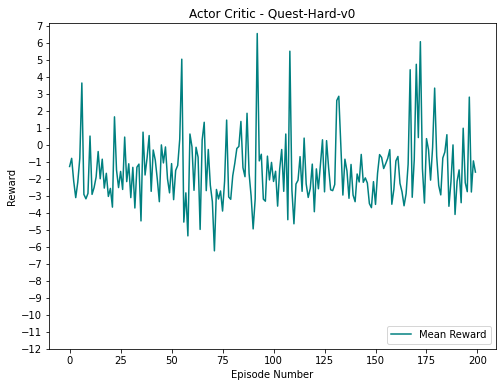

In [ ]:
plot_results(env_name="Quest-Hard-v0",scores=q_hard_out,ylim=(-12,8), color = "blue" )

In [ ]:
save_video_of_model(agent, env, "a2c_q_hard_1")

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


[MoviePy] >>>> Building video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c_q_hard_1.mp4
[MoviePy] Writing video /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c_q_hard_1.mp4


100%|██████████| 1001/1001 [00:06<00:00, 145.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/Shareddrives/RL_MiniHack/A2C_Agents/videos/a2c_q_hard_1.mp4 

